# Task 1: Simulating Fisher-Wright

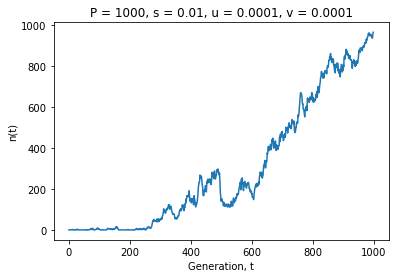

[(0, 0),
 (1, 0),
 (2, 0),
 (3, 0),
 (4, 0),
 (5, 0),
 (6, 0),
 (7, 0),
 (8, 1),
 (9, 1),
 (10, 1),
 (11, 2),
 (12, 2),
 (13, 0),
 (14, 0),
 (15, 0),
 (16, 0),
 (17, 0),
 (18, 0),
 (19, 0),
 (20, 1),
 (21, 2),
 (22, 1),
 (23, 0),
 (24, 0),
 (25, 0),
 (26, 0),
 (27, 1),
 (28, 4),
 (29, 3),
 (30, 2),
 (31, 0),
 (32, 0),
 (33, 0),
 (34, 0),
 (35, 0),
 (36, 0),
 (37, 0),
 (38, 0),
 (39, 0),
 (40, 0),
 (41, 0),
 (42, 0),
 (43, 0),
 (44, 0),
 (45, 0),
 (46, 0),
 (47, 0),
 (48, 0),
 (49, 0),
 (50, 0),
 (51, 0),
 (52, 0),
 (53, 1),
 (54, 1),
 (55, 0),
 (56, 0),
 (57, 0),
 (58, 0),
 (59, 1),
 (60, 0),
 (61, 1),
 (62, 0),
 (63, 0),
 (64, 0),
 (65, 0),
 (66, 1),
 (67, 1),
 (68, 2),
 (69, 2),
 (70, 2),
 (71, 5),
 (72, 5),
 (73, 7),
 (74, 6),
 (75, 2),
 (76, 2),
 (77, 3),
 (78, 8),
 (79, 3),
 (80, 2),
 (81, 2),
 (82, 0),
 (83, 0),
 (84, 0),
 (85, 0),
 (86, 1),
 (87, 1),
 (88, 2),
 (89, 2),
 (90, 4),
 (91, 6),
 (92, 5),
 (93, 8),
 (94, 10),
 (95, 9),
 (96, 4),
 (97, 6),
 (98, 6),
 (99, 3),
 (100, 3)

In [1]:
import numpy as np
import scipy
import matplotlib.pyplot as plt
%matplotlib inline
from functools import partial

rng = np.random.default_rng()

def psm(n, P, s, u, v):
    """We heavily reuse this"""
    ps = (1+s)*n/(P+n*s)
    return (1-v)*ps + u*(1-ps)

def updateFW(n, P, s, u, v):
    """Generate a new population of size P starting with n individuals of type B"""
    return rng.binomial(P, psm(n, P, s, u, v))

class FisherWright():
    """Simulate the Dynamics of the Fisher-Wright Model
    We create an iterator to this"""
    
    def __init__(self, param):
        "create a function with the parameter set apart form n"
        self.update = partial(updateFW, **param)
        
    def __iter__(self):
        n = self.n0
        #this is just for lazy evaluation, I think?
        yield n
        while True:
            n = self.update(n)
            yield n

    def __call__(self, n0):
        """initiate n0 and return iterator"""
        self.n0 = n0
        return iter(self)

param = {"P": 1000, "s": 0.01, "u": 0.0001, "v": 0.0001}

fisherWright = FisherWright(param)

T = 10000

#returns a tuple list of data points of the generation number and the value of n(t)
def evolution(model, n0, T, transform=lambda x: x):
    """Run the model for T generations starting from n0
        transform the output of the model with default of doing nothing"""
    it = model(n0)                # create a new iterator
    return [(i, transform(next(it))) for i in range(T)]

#wrap the code to run and show the results of the fisher wright evolution into a resusable function
def show_FW(nGens):
    
    #
    evo = evolution(fisherWright, 0, nGens)
    
    def dict_to_str(dic):
        return ", ".join([f"{key} = {value}" for (key,value) in param.items()])

    plt.plot(*zip(*evo))        # weird trick to get matplotlib to plot a list of (x,y) pairs
    plt.xlabel("Generation, t")
    plt.ylabel("n(t)")
    plt.title(dict_to_str(param))
    plt.show()
    return evo

show_FW(1000)

In [4]:
def calc_takeover_time(param_dict):
    
    model = FisherWright(param_dict)
    
    #lets take the initial generation number to always be 0
    for gen_num, val in enumerate(model(0)):
        
        if(val >= 0.95 * param_dict['P']):
            return gen_num

In [5]:
def investigate_s_dependance():
    
    #the s value will be timesed by 10 on each iteration
    params = {'P': 10000, 's': 0.0001, 'u': 0.0001, 'v': 0.0001}
    
    #y axis will be takeover time
    #x axis will be s value
    
    #tuples of the s value paired with the takeover time
    data_points = []
    
    for i in range(20):
        
        data_points.append((params['s'], calc_takeover_time(params)))
        params['s'] *= 10
    

    
    plt.plot(*zip(*data_points))
    plt.xlabel("Selection strength (s), log scale")
    plt.ylabel("Takeover time, log scale")
    plt.yscale("log")
    plt.xscale("log")
    plt.title("How takover time varies depending on different s values")
    plt.show()
    
    return data_points

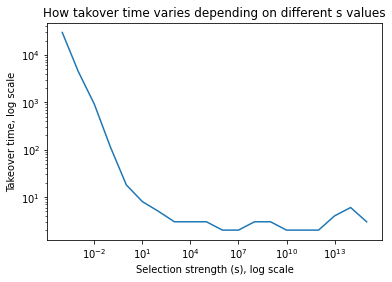

[(0.0001, 29840),
 (0.001, 4468),
 (0.01, 916),
 (0.1, 115),
 (1.0, 18),
 (10.0, 8),
 (100.0, 5),
 (1000.0, 3),
 (10000.0, 3),
 (100000.0, 3),
 (1000000.0, 2),
 (10000000.0, 2),
 (100000000.0, 3),
 (1000000000.0, 3),
 (10000000000.0, 2),
 (100000000000.0, 2),
 (1000000000000.0, 2),
 (10000000000000.0, 4),
 (100000000000000.0, 6),
 (1000000000000000.0, 3)]

In [6]:
investigate_s_dependance()

In [5]:
def investigate_mut_dependance():
    
    #the s value will be timesed by 10 on each iteration
    params = {'P': 10000, 's': 0.01, 'u': 0.00001, 'v': 0.000001}
    
    #y axis will be takeover time
    #x axis will be s value
    
    #tuples of the s value paired with the takeover time
    data_points = []
    
    for i in range(15):
        
        print("it number:", i)
        
        #u and v will always be the same so just pick either
        data_points.append((params['u'], calc_takeover_time(params)))
        params['u'] *= 2
        params['v'] *= 2
    
    plt.plot(*zip(*data_points))
    plt.xlabel("Mutation rate (m), linear scale")
    plt.ylabel("Takeover time, log scale")
    plt.yscale("log")
    plt.title("How takover time varies depending on the mutation rate")
    plt.show()
    return data_points

In [6]:
investigate_mut_dependance()

it number: 0
it number: 1
it number: 2
it number: 3
it number: 4
it number: 5
it number: 6
it number: 7
it number: 8
it number: 9
it number: 10
it number: 11
it number: 12
it number: 13


KeyboardInterrupt: 

In [113]:
def investigate_P_dependance():
    
    #the s value will be timesed by 10 on each iteration
    params = {'P': 100, 's': 0.01, 'u': 0.0001, 'v': 0.0001}
    
    #y axis will be takeover time
    #x axis will be s value
    
    #tuples of the s value paired with the takeover time
    data_points = []
    
    for i in range(15):
        
        #u and v will always be the same so just pick either
        data_points.append((params['P'], calc_takeover_time(params)))
        params['P'] *= 10
    
    plt.plot(*zip(*data_points))
    plt.xlabel("Population size (P), log scale")
    plt.ylabel("Takeover time, linear scale")
    #plt.yscale("log")
    plt.xscale("log")
    plt.title("How takover time varies depending on the population size")
    plt.show()

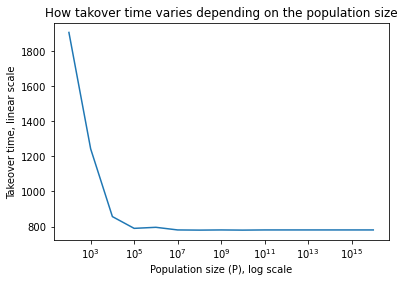

In [114]:
investigate_P_dependance()

# Task 2: Multiple runs

In [ ]:
#assume a model is something that when run, returns a list of tuples
#where the first element of each tuple is the number generation
#and the second element is some value
def multiple_runs(model, n_runs)

    